# Gradient Boosted Models

Gradient Boosting does not refer to one particular model, but a versatile framework to optimize many loss functions. It follows the strength in numbers principle by combining the predictions of multiple *base learners* to obtain a powerful overall model. The base learners are often very simple models that are only slightly better than random guessing, which is why they are also referred to as *weak learners*. The predictions are combined in an additive manner, where the addition of each base model improves (or "boosts") the overall model. Therefore, the overall model $f$ is an additive model of the form:

$$
\begin{equation}
f(\mathbf{x}) = \sum_{m=1}^M \beta_m g(\mathbf{x}; {\theta}_m),
\end{equation}
$$

where $M > 0$ denotes the number of base learners, and $\beta_m \in \mathbb{R}$ is a weighting term. The function $g$ refers to a *base learner* and is parameterized by the vector ${\theta}$. Individual base learners differ in the configuration of their parameters ${\theta}$, which is indicated by a subscript $m$.

A gradient boosted model is similar to a [Random Survival Forest](random-survival-forest.ipynb), in the sense that it relies on multiple base learners to produce an overall prediction, but differs in how those are combined. While a Random Survival Forest fits a set of Survival Trees independently and then averages their predictions, a gradient boosted model is constructed sequentially in a greedy stagewise fashion.

## Base Learners

Depending on the loss function to be minimized and base learner used, different models arise. 
[sksurv.ensemble.GradientBoostingSurvivalAnalysis](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.ensemble.GradientBoostingSurvivalAnalysis.html#sksurv.ensemble.GradientBoostingSurvivalAnalysis) implements gradient boosting with regression tree base learner, and
[sksurv.ensemble.ComponentwiseGradientBoostingSurvivalAnalysis](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.ensemble.ComponentwiseGradientBoostingSurvivalAnalysis.html#sksurv.ensemble.ComponentwiseGradientBoostingSurvivalAnalysis) uses component-wise least squares as base learner. The former is very versatile and can account for complicated non-linear relationships between features and time to survival. When using component-wise least squares as base learner, the final model will be a linear model, but only a small subset of features will be selected, similar to the [LASSO penalized Cox model](coxnet.ipynb#LASSO).


## Losses

### Cox's Partial Likelihood

The loss function can be specified via the `loss` argument loss; the default loss function  is the partial likelihood loss of [Cox's proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model) (`coxph`). Therefore, the objective is to maximize the log partial likelihood function, but replacing the traditional linear model $\mathbf{x}^\top \beta$ with the additive model $f(\mathbf{x})$:

$$
\begin{equation}
  \arg \min_{f} \quad \sum_{i=1}^n \delta_i \left[ f(\mathbf{x}_i)
- \log \left( \sum_{j \in \mathcal{R}_i} \exp(f(\mathbf{x}_j)) \right) \right] .
\end{equation}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

To demonstrate its use we are going to use the [breast cancer data](https://clincancerres.aacrjournals.org/content/13/11/3207), which contains the expression levels of 76 genes, age, estrogen receptor status (`er`), tumor size and grade for 198 individuals. The objective is to predict the time to distant metastasis.

First, we load the data and perform one-hot encoding of categorical variables `er` and `grade`.

In [2]:
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=0)

Next, we are using gradient boosting on Cox's partial likelihood with regression trees base learners, which we restrict to using only a single split (so-called *stumps*).

In [3]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.756


This model achieves a concordance index of 0.756 on the test data. Let's see how the test performance changes with the ensemble size (`n_estimators`).

In [4]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

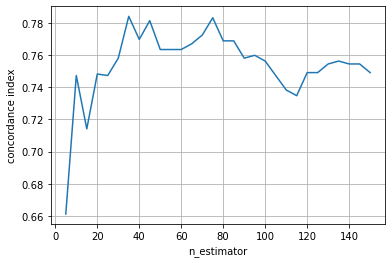

In [5]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

We can see that the performance quickly improves, but also that the performance starts to decrease if the ensemble becomes too big.

Let's repeat the analysis using component-wise least squares base learners.

In [6]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0, random_state=0)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

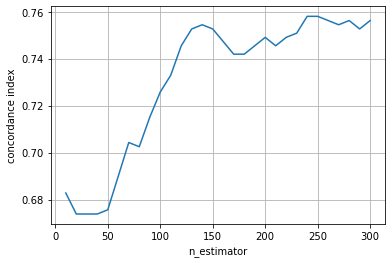

In [7]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

The performance increase is much slower here and its maximum performance seems to be below that of the ensemble of tree-based learners. This is not surprising, because with component-wise least squares base learners the overall ensemble is a linear model, whereas with tree-based learners it will be a non-linear model.

The coefficients of the model can be retrieved as follows:

In [8]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + Xt.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 9


er=positive          -0.837549
X207118_s_at          0.239161
grade=unkown         -0.234126
size                  0.214384
X204540_at            0.094421
X204014_at           -0.091377
X216103_at           -0.086147
X221916_at           -0.081565
grade=intermediate    0.065916
dtype: float64

Despite using hundreds of iterations, the resulting model is very parsimonious and easy to interpret.

### Accelerated Failure Time Model

The Accelerated Failure Time (AFT) model is an alternative to [Cox's proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model). The latter assumes that features only influence the hazard function via a constant multiplicative factor. In contrast, features in an AFT model can accelerate or decelerate the time to an event by a constant factor. The figure below depicts the predicted hazard functions of a proportional hazards model in blue and that of an AFT model in orange.



We can see that the hazard remains constant for the proportional hazards model and varies for the AFT model.

The objective function in an AFT model can be expressed as a weighted least squares problem with respect to the logarithm of the survival time:

$$
\begin{equation}
  \arg \min_{f} \quad \frac{1}{n} \sum_{i=1}^n
    \omega_i (\log y_i - f(\mathbf{x}_i)) .
\end{equation}
$$

The weight $\omega_i$ associated with the $i$-th sample is the inverse probability of being censored after time $y_i$:

$$
\begin{equation}
  \omega_i = \frac{\delta_i}{\hat{G}(y_i)} ,
\end{equation}
$$

where $\hat{G}(\cdot)$ is an estimator of the censoring survivor function.

Such a model can be fit with [sksurv.ensemble.GradientBoostingSurvivalAnalysis](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.ensemble.GradientBoostingSurvivalAnalysis.html#sksurv.ensemble.GradientBoostingSurvivalAnalysis) or
[sksurv.ensemble.ComponentwiseGradientBoostingSurvivalAnalysis](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.ensemble.ComponentwiseGradientBoostingSurvivalAnalysis.html#sksurv.ensemble.ComponentwiseGradientBoostingSurvivalAnalysis)
by specifying the `loss="ipcwls"` argument.

In [9]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

0.722


## Regularization

The most important parameter in gradient boosting is the number of base learner to use (`n_estimators` argument). A higher number will lead to a more complex model. However, this can easily lead to overfitting on the training data. The easiest way would be to just use less base estimators, but there are three alternatives to combat overfitting:

1. Use a `learning_rate` less than 1 to restrict the influence of individual base learners, similar to the [Ridge penalty](coxnet.ipynb#Ridge).
2. Use a non-zero `dropout_rate`, which forces base learners to also account for some of the previously fitted base learners to be missing.
3. Use `subsample` less than 1 such that each iteration only a portion of the training data is used. This is also known as *stochastic gradient boosting*.

In [10]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0),
    "learning rate": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=1, random_state=0),
    "dropout": GradientBoostingSurvivalAnalysis(learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0),
    "subsample": GradientBoostingSurvivalAnalysis(learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

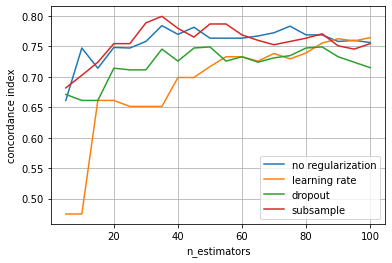

In [11]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

The plot reveals that using dropout or a learning rate are most effective in avoiding overfitting. Moreover, the learning rate and ensemble size are strongly connected, choosing smaller a learning rate suggests increasing `n_estimators`. Therefore, it is recommended to use a relatively small learning rate and select the number of estimators via *early stopping*. Note that we can also apply multiple types of regularization, such as regularization by learning rate and subsampling. Since not all training data is used, this allows using the left-out data to evaluate whether we should continue adding more base learners or stop training.

In [12]:
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

Fitted base learners: 119
Performance on test set 0.703


The monitor looks at the average improvement of the last 25 iterations, and if it was negative for the last 50 iterations, it will abort training. In this case, this occurred after 119 iterations. We can plot the improvement per base learner and the moving average.

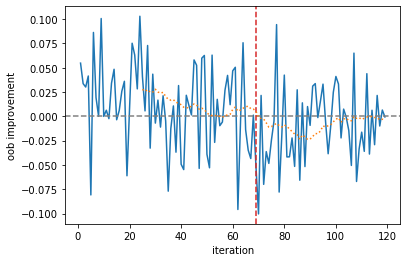

In [13]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_, index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")